In [569]:
import numpy as np
import numpy.random as rnd
import scipy.integrate as itg
import torch as pt
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

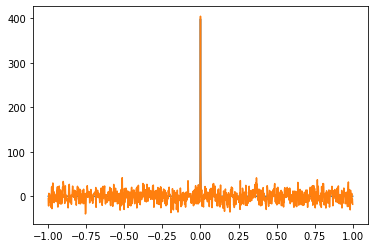

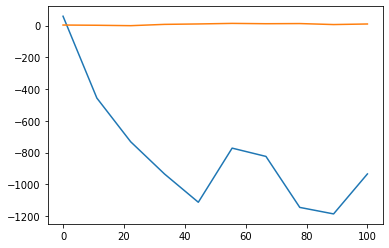

In [351]:
NumFeatures = 1001

sigma = .001

x_plot = np.linspace(-1,1,NumFeatures)

plt.plot(x_plot,np.exp(-x_plot**2 / (2*sigma**2))/(np.sqrt(2*np.pi)*sigma))

Omega = rnd.randn(NumFeatures) / sigma
B = np.pi * rnd.rand(NumFeatures)
V = rnd.randn(NumFeatures)

def fourierFeatures(x,Omega,B,sigma):
    n = len(Omega)
    Z = np.sqrt(2/(np.sqrt(2*np.pi)*sigma*n)) * np.cos(np.outer(x,Omega)+np.outer(np.ones_like(x),B))
    return Z

def approximateWhite(x,Omega,B,V,sigma):
    Z = fourierFeatures(x,Omega,B,sigma)
    return Z@V

Z = fourierFeatures(x_plot,Omega,B,sigma)


K = Z@Z.T
plt.plot(x_plot,K[int((NumFeatures-1)/2)])

plt.figure()
Time = np.linspace(0,100,10)
W = approximateWhite(Time,Omega,B,V,sigma)
dt = Time[1]-Time[0]
plt.plot(Time,dt*np.cumsum(W))
plt.plot(Time,np.sqrt(dt)*np.cumsum(rnd.randn(len(Time))))

In [113]:
K.shape

(101, 101)

In [497]:
def stratonovichFlow(x,sigma_fun):
    sigma = sigma_fun(x)
    m,n = sigma.shape
    
    diff_tensor_list = []
    for i in range(m):
        rows = []
        for j in range(n):
            # Zero the gradient
            x.grad = pt.zeros_like(x)
            sigma_ij = sigma[i,j]
            sigma_ij.backward(retain_graph=True)
            rows.append(x.grad)
        
        mat = pt.stack(rows)
        diff_tensor_list.append(mat)
        
    diff_tensor = pt.stack(diff_tensor_list)
    f = pt.einsum('ijk,kj -> i', diff_tensor,sigma)
    
    return f

In [498]:
def sphereLC(x,R=1.):
    """
    Levi-Civita connection on a sphere in a stereographic projection from the north pole
    """
    
    n = len(x)
    I = pt.eye(n)
    c = 2/(R**2 + pt.sum(x**2))
    
    d_ijk = pt.einsum('ij,k -> kij',I,x)
    d_ikj = pt.einsum('ik,j -> kij',I,x)
    d_jki = pt.einsum('jk,i -> kij',I,x)
    
    Gamma = c * (d_ijk - d_ikj - d_jki)
    return Gamma

def sphere_g(x,R=1.):
    """
    Riemannian metric on a sphere in a sterographic projection from the north pole
    """
    
    c = (2*R**2 / (R**2 + pt.sum(x**2)))**2
    n = len(x)
    return c * pt.eye(n)

def extractState(y):
    m = len(y)
    n = int((np.sqrt(1+4*m)-1)/2)
    x = y[:n]
    e = y[n:].reshape((n,n)).T
    
    return x,e

def flattenState(x,e):
    return pt.cat([x,e.T.flatten()])
    

def riemannianSigma(y,Gamma_fun):
    """
    y is a flattened version of (x,e) where
       x is the point on the manifold 
       e is an orthogonal matrix
    Gamma_fun is a function for the Levi-Civita connection
    """
    x,e = extractState(y)
    
    Gamma = Gamma_fun(x)
    
    n = len(x)
    e_tensor = -pt.einsum('kij,ja,ib -> akb',Gamma,e,e)
    e_mat = pt.reshape(e_tensor,(n*n,n))
    
    return pt.cat([e,e_mat],dim=0)
    
def makeLC_fun(g_fun):
    def Gamma_fun(x):
        g = g_fun(x)
        g_inv = pt.inverse(g)
        
        n = len(x)
        grad_tensor_list = []
        
        for i in range(n):
            i_list = []
            for j in range(n):
                x.grad = pt.zeros_like(x)
                gij = g[i,j]
                gij.backward(retain_graph=True)
                i_list.append(x.grad)
                
            mat = pt.stack(i_list)
            grad_tensor_list.append(mat)
            
        grad_tensor = pt.stack(grad_tensor_list)
        
        grad_sum = -grad_tensor + pt.einsum('ijk-> kij',grad_tensor) + pt.einsum('ijk -> jki',grad_tensor)
        Gamma = .5 * pt.einsum('ak,ijk -> aij', g_inv,grad_sum)
        
        return Gamma
    
    return Gamma_fun
            
                

    
def orthogonalize(y,g_fun):
    x,e_hat = extractState(y)
    
    g = g_fun(x)
    
    c = pt.cholesky(g,upper=True)
    
    q,r = pt.qr(c@e_hat)
    e_sol = pt.triangular_solve(q,c)
    e = e_sol.solution
    return flattenState(x,e)
    
    
def stereographicProjN(x,R=1.):
    n = len(x)-1
    ksi = x[:n]
    tau = x[-1]
    
    return (R/(R-tau)) * ksi

def stereographicProjS(x,R=1.):
    n = len(x)-1
    ksi = x[:n]
    tau = x[-1]
    return (R/(R+tau)) * ksi

def stereographicProjN_inv(x,R=1.):
    nmSq = pt.sum(x**2)
    ksi = (2*R**2/(R**2 + nmSq)) * x
    tau = R * ((nmSq-R**2)/(nmSq+R**2))
    return pt.cat([ksi,tau.view((1,))])

def stereographicProjS_inv(x,R=1.):
    nmSq = pt.sum(x**2)
    ksi = (2*R**2/(R**2 + nmSq)) * x
    tau = -R * ((nmSq-R**2)/(nmSq+R**2))
    return pt.cat([ksi,tau.view((1,))])
    
    
def swapProjections(x,R=1.):
    return (R/pt.norm(x))**2 * x

def swapJacobian(x,R=1.):
    n = len(x)
    nmSq = pt.sum(x**2)
    
    J = (R**2/nmSq)*(pt.eye(n)-2*pt.ger(x,x)/nmSq)
    return J

In [499]:
n = 2
x = pt.randn(n,requires_grad=True)
#x = pt.tensor([1.,0],requires_grad=True)
print(x)

g = sphere_g(x)


c = pt.cholesky(g,upper=True)

e_hat = pt.randn(n,n)

e_hat = pt.eye(n)
y_hat = flattenState(x,e_hat)

y = orthogonalize(y_hat,sphere_g)
_,e = extractState(y)


sigma = riemannianSigma(y,sphereLC)

w = pt.randn(n)

y_dot = sigma@w

x_dot,e_dot = extractState(y_dot)

g_dot_list = []
for i in range(n):
    row = []
    for j in range(n):
        
        gij = g[i,j]
        gij.backward(retain_graph=True)
        row.append(x.grad@x_dot)
        
        x.grad = pt.zeros_like(x)
    g_dot_list.append(pt.stack(row))
    
g_dot = pt.stack(g_dot_list)

    

tensor([0.3616, 0.0451], requires_grad=True)


100%|██████████| 10000/10000 [01:04<00:00, 156.23it/s]


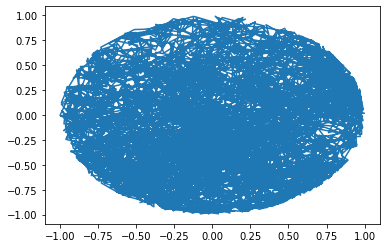

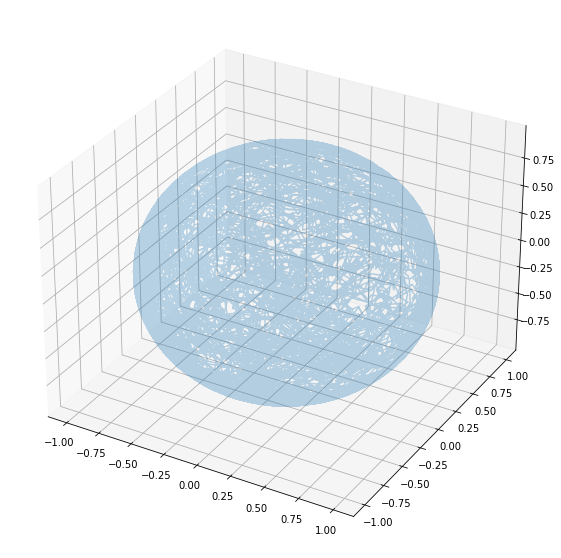

In [570]:
# Run Brownian Motion in the north pole stereographic projection coordinates
n = 2
s = pt.randn(n+1)

sign = pt.sign(s[-1])

if sign > 0:
    x = stereographicProjS(s)
else:
    x = stereographicProjN(s)
e = pt.eye(n)
y = flattenState(x,e)
y = y.detach().clone().requires_grad_(True)
X = []
Sign = []
S = []

NumSteps = 10000
dt = .01
dRt = np.sqrt(dt)
sigma_fun = lambda y : riemannianSigma(y,sphereLC)

W = pt.randn(NumSteps,n)

for step in tqdm(range(NumSteps)):
    x,e = extractState(y)
    
    if sign > 0:
        s = stereographicProjS_inv(x)
    else:
        s = stereographicProjN_inv(x)
        
    S.append(s)
    X.append(x)
    
    sigma = riemannianSigma(y,sphereLC)
    f = stratonovichFlow(y,sigma_fun)
    
    y = orthogonalize(y + dt * f + dRt * sigma@W[step],sphere_g)
    
    x,e = extractState(y)
    if pt.norm(x) > 1:
        # Flip sign
        # move to the other chart
        sign = -1 * sign
        J = swapJacobian(x)
        e = J@e
        x = swapProjections(x)
        
    y = flattenState(x,e)
        
        
        
    
    y = y.detach().clone().requires_grad_(True)
    

    
    
    
X = pt.stack(X)


X_np = X.detach().numpy()
plt.plot(X_np[:,0],X_np[:,1])


ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
S_np = pt.stack(S).detach().numpy()
ax.plot(S_np[:,0],S_np[:,1],S_np[:,2],alpha=.3)


In [571]:
x_N = x
e_N = e
g_N = sphere_g(x_N)

x_S = swapProjections(x_N)
J = swapJacobian(x_N)
e_S = J@e_N
g_S = sphere_g(x_S)



print(e_N.T@g_N@e_N)
print(e_S.T@g_S@e_S)


tensor([[ 1.0000e+00, -9.6858e-08],
        [-8.1956e-08,  1.0000e+00]], grad_fn=<MmBackward>)
tensor([[ 1.0000e+00, -8.9407e-08],
        [-8.9407e-08,  1.0000e+00]], grad_fn=<MmBackward>)


In [531]:
print(g_)

tensor([[2.9905, 0.0000],
        [0.0000, 2.9905]], grad_fn=<MulBackward0>)

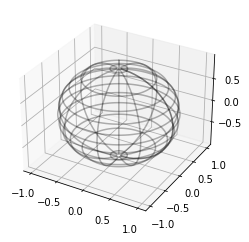

In [464]:
ax = plt.figure().add_subplot(projection='3d')


Theta = pt.linspace(0,2*np.pi,100)

for tau in pt.linspace(-.99,.99,11):
    x_plot = np.sqrt((1+tau)/(1-tau)) * pt.stack([pt.cos(Theta),pt.sin(Theta)],dim=1)

    s_plot = pt.stack([stereographicProjN_inv(x) for x in x_plot]).detach().numpy().T
    ax.plot(s_plot[0],s_plot[1],s_plot[2],color='k',alpha=.3)
    
Tau = pt.linspace(-.999,.999,100)
for theta in pt.linspace(0,2*np.pi,10):
    x = pt.stack([pt.cos(theta),pt.sin(theta)])
    x_plot = pt.stack([pt.sqrt((1+tau)/(1-tau)) * x for tau in Tau])
    
    s_plot = pt.stack([stereographicProjN_inv(x) for x in x_plot]).detach().numpy().T
    ax.plot(s_plot[0],s_plot[1],s_plot[2],color='k',alpha=.3)

In [403]:
Gamma = sphereLC(x)
print(Gamma)
print(g)
print(sigma)
print(e_dot)
print(g_dot)

tensor([[[-1.,  0.],
         [ 0.,  1.]],

        [[ 0., -1.],
         [-1.,  0.]]], grad_fn=<MulBackward0>)
tensor([[1., 0.],
        [0., 1.]], grad_fn=<MulBackward0>)
tensor([[ 1.,  0.],
        [-0.,  1.],
        [ 1., -0.],
        [-0.,  1.],
        [-0., -1.],
        [ 1., -0.]], grad_fn=<CatBackward>)
tensor([[ 0.3869,  1.1113],
        [-1.1113,  0.3869]], grad_fn=<PermuteBackward>)
tensor([[0., 0.],
        [0., 0.]], grad_fn=<StackBackward>)


In [401]:
print(y_dot)
print(e_dot)

tensor([ 0.3869, -1.1113,  0.3869, -1.1113,  1.1113,  0.3869],
       grad_fn=<MvBackward>)
tensor([[ 0.3869,  1.1113],
        [-1.1113,  0.3869]], grad_fn=<PermuteBackward>)
